In [1]:
!pip install transformers torch matplotlib seaborn pandas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler


In [3]:
df = pd.read_csv('Reviews.csv', encoding='ISO-8859-1')
df = df[['Score', 'Summary', 'Text']].rename(columns={'Score': 'Rating', 'Text': 'Review'})
df = df.drop_duplicates(subset=['Review']).dropna()
df = df.loc[df['Rating'] <= 5]

In [ ]:
#dataset is sampled to get 50k reviews to be belanced 
first_sample = df[df['Rating'] == 1].sample(n=10000, random_state=42)
second_sample = df[df['Rating'] == 2].sample(n=10000, random_state=42)
third_sample = df[df['Rating'] == 3].sample(n=10000, random_state=42)
fourth_sample = df[df['Rating'] == 4].sample(n=10000, random_state=42)
fifth_sample = df[df['Rating'] == 5].sample(n=10000, random_state=42)
df = pd.concat([first_sample, second_sample, third_sample, fourth_sample, fifth_sample]).sample(frac=1, random_state=42).reset_index(drop=True)


In [5]:
df.count()

,0
Rating,50000
Summary,50000
Review,50000


In [ ]:
#data preprocessing of the dataset
rating_to_sentiment = {5: 'Positive', 4: 'Positive', 3: 'Neutral', 2: 'Negative', 1: 'Negative'}
df['Sentiment'] = df['Rating'].map(rating_to_sentiment)
df['Summary_Review'] = df['Summary'].astype(str) + " " + df['Review'].astype(str)
df = df[['Summary_Review', 'Sentiment']]
sentiment_to_label = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['Label'] = df['Sentiment'].map(sentiment_to_label)

In [ ]:
#splitting the dataset into train and test data
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)

In [8]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(text, max_length=self.max_len, truncation=True, padding="max_length", return_tensors="pt")
        return {'input_ids': encoding['input_ids'].squeeze(0), 'attention_mask': encoding['attention_mask'].squeeze(0), 'labels': torch.tensor(label, dtype=torch.long)}


In [ ]:
#initializing the distil bert model
pretrained_model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = SentimentDataset(train_data['Summary_Review'], train_data['Label'], tokenizer)
test_dataset = SentimentDataset(test_data['Summary_Review'], test_data['Label'], tokenizer)

#Training and testing data on a batch size of 16 is taken and passed through the data loader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#optimizer used is AdamW to avoid overfitting
optimizer = AdamW(model.parameters(), lr=2e-5)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_model(model, train_loader, optimizer, lr_scheduler, device):
    """
    Function to train the model, input_ids and attention_mask elements created for the model to take as input,
    logits are taken and passed through softmax activation function
    It returns the training loss and the accuracy at each step

    Args:
    - model: The model to work with
    - tarin_loader: trained data
    - lr_scheduler: linear scheduler 
    - device: Device (CPU/GPU).

    Returns:
    - Loss and Accuracy 
    """
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
    return total_loss / len(train_loader), correct / total

In [ ]:
def evaluate_model(model, data_loader, device):
    """
    Function to evaluate the model using the two elements, logits are passed here and predictions, 
    true labels are appended for each review 

    Args:
    - model: The model to work with
    - data_loader: the reviews dataset
    - device: Device (CPU/GPU).

    Returns:
    - Predictions and true labels.
    """
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

In [ ]:
#Epochs execution for the model, prints loss and accuracy for each epoch
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss, train_accuracy = train_model(model, train_loader, optimizer, lr_scheduler, device)
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

Epoch 1/10
Training Loss: 0.5588, Training Accuracy: 0.7641
Epoch 2/10
Training Loss: 0.4316, Training Accuracy: 0.8200
Epoch 3/10
Training Loss: 0.3345, Training Accuracy: 0.8646
Epoch 4/10
Training Loss: 0.2896, Training Accuracy: 0.8860
Epoch 5/10
Training Loss: 0.2902, Training Accuracy: 0.8866
Epoch 6/10
Training Loss: 0.2912, Training Accuracy: 0.8860
Epoch 7/10
Training Loss: 0.2913, Training Accuracy: 0.8859
Epoch 8/10
Training Loss: 0.2901, Training Accuracy: 0.8861
Epoch 9/10
Training Loss: 0.2893, Training Accuracy: 0.8875
Epoch 10/10
Training Loss: 0.2903, Training Accuracy: 0.8865


In [ ]:
#saving the fine tuned model
model.save_pretrained("ten_fine_tuned_distilbert")
tokenizer.save_pretrained("ten_fine_tuned_distilbert")

('ten_fine_tuned_distilbert/tokenizer_config.json',
 'ten_fine_tuned_distilbert/special_tokens_map.json',
 'ten_fine_tuned_distilbert/vocab.txt',
 'ten_fine_tuned_distilbert/added_tokens.json',
 'ten_fine_tuned_distilbert/tokenizer.json')

In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd

In [17]:
# Load the fine-tuned model and tokenizer
model_path = "ten_fine_tuned_distilbert"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [18]:
# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [19]:
# Function to evaluate the model on the test dataset
def evaluate_test_data(test_data, model, tokenizer, device):
    """
    Evaluate the model on the test dataset.

    Args:
    - test_data (DataFrame): The test dataset with reviews and true labels.
    - model: The fine-tuned model.
    - tokenizer: Tokenizer used for the fine-tuned model.
    - device: Device (CPU/GPU).

    Returns:
    - DataFrame with reviews, true labels, predicted labels, and confidence scores.
    """
    model.eval()
    reviews = test_data['Summary_Review'].tolist()
    true_labels = test_data['Label'].tolist()
    predictions, confidence_scores = [], []

    for review in reviews:
        # Tokenize the review
        inputs = tokenizer(
            review,
            max_length=128,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).to(device)

        # Get predictions
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)

        # Get the predicted label and confidence score
        predicted_label = torch.argmax(probs, dim=1).item()
        confidence_score = probs[0, predicted_label].item()

        predictions.append(predicted_label)
        confidence_scores.append(confidence_score)

    # Add predictions and confidence scores to the DataFrame
    test_data['Predicted_Label'] = predictions
    test_data['Confidence_Score'] = confidence_scores

    # Map numeric labels back to sentiment names
    label_to_sentiment = {0: "Negative", 1: "Neutral", 2: "Positive"}
    test_data['Predicted_Sentiment'] = test_data['Predicted_Label'].map(label_to_sentiment)
    test_data['True_Sentiment'] = test_data['Label'].map(label_to_sentiment)

    return test_data

# Evaluate on the test dataset
results_df = evaluate_test_data(test_data, model, tokenizer, device)

# Calculate overall accuracy
accuracy = (results_df['Predicted_Label'] == results_df['Label']).mean()
print(f"Test Accuracy: {accuracy:.4f}")

# Display a few predictions
print(results_df[['Summary_Review', 'True_Sentiment', 'Predicted_Sentiment', 'Confidence_Score']].head())

# Optional: Save results to a CSV
results_df.to_csv("test_results.csv", index=False)



Test Accuracy: 0.7950
                                          Summary_Review True_Sentiment  \
10939  Pretty nice! I got a pack of these today and I...       Positive   
20326  Better, Smoother Than Emeril's Big Easy Bold U...       Positive   
32873  Awesome Instant coffee! I am a major coffee dr...       Positive   
43764  I like this one a lot Since I got my Keurig Br...       Positive   
40770  Doesn't taste at all like cotton Candy I love ...       Negative   

      Predicted_Sentiment  Confidence_Score  
10939            Positive          0.922798  
20326            Positive          0.979424  
32873            Positive          0.997287  
43764            Positive          0.977223  
40770            Negative          0.967858  


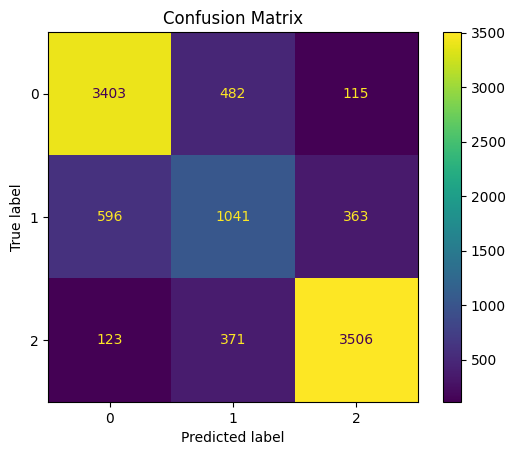

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming your class labels are integers, get unique classes
unique_classes = sorted(results_df['Label'].unique())

# Calculate confusion matrix
true_labels = results_df['Label']
predicted_labels = results_df['Predicted_Label']
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()

In [21]:
report = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      4000
           1       0.55      0.52      0.53      2000
           2       0.88      0.88      0.88      4000

    accuracy                           0.80     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.79      0.80      0.79     10000

